In [41]:
import pandas as pd
import metpy
from siphon.catalog import TDSCatalog
from metpy.io import parse_metar_file
from datetime import datetime, timedelta
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
from metpy.plots import USCOUNTIES
import matplotlib.pyplot as plt


In [42]:
md_time = datetime(2023, 9, 18, 18, 00)
metar_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')
sfc_obs = parse_metar_file(metar_cat.datasets.filter_time_nearest(md_time).remote_open(mode='t'))
sfc_obs = sfc_obs.set_index('date_time').groupby('station_id').first()
df = sfc_obs

print(df)


            latitude  longitude  elevation  wind_direction  wind_speed  \
station_id                                                               
BGBW           61.17     -45.42       26.0           260.0    5.000000   
BGGH           64.20     -51.68       70.0            60.0    8.000000   
BGJN           69.25     -51.07       25.0           310.0    4.000000   
BGKK           65.56     -37.13       34.0           250.0    7.000000   
BGSF           67.00     -50.72       53.0            60.0    6.000000   
...              ...        ...        ...             ...         ...   
ZWWW           43.88      87.47      654.0           180.0    3.887689   
ZYCC           43.98     125.68      238.0           230.0    9.719222   
ZYHB           45.62     126.25      140.0           210.0    9.719222   
ZYTL           38.97     121.53       97.0             NaN    1.943844   
ZYTX           41.63     123.48       35.0           260.0    1.943844   

            wind_gust  visibility cur

In [43]:
great_lakes_centers = {
    'Superior': {'lon': -88.0, 'lat': 46.5},
    'Michigan': {'lon': -86.5, 'lat': 44.0},
    'Huron': {'lon': -83.5, 'lat': 44.0},
    'Erie': {'lon': -81.0, 'lat': 41.5},
    'Ontario': {'lon': -77.5, 'lat': 43.0}
}

filtered_data = pd.DataFrame()

lat_extension = 1
lon_extension = 1

metar_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

for lake_name, lake_center in great_lakes_centers.items():
    lake_bbox = [
        lake_center['lon'] - lon_extension,  # Westernmost Longitude
        lake_center['lon'] + lon_extension,  # Easternmost Longitude
        lake_center['lat'] - lat_extension,  # Southernmost Latitude
        lake_center['lat'] + lat_extension   # Northernmost Latitude
    ]

    sfc_obs = metar_cat.datasets.filter_time_nearest(md_time).remote_open(mode='t')
    sfc_obs = parse_metar_file(sfc_obs)

    sfc_obs = sfc_obs[
        (sfc_obs['longitude'] >= lake_bbox[0]) &
        (sfc_obs['longitude'] <= lake_bbox[1]) &
        (sfc_obs['latitude'] >= lake_bbox[2]) &
        (sfc_obs['latitude'] <= lake_bbox[3])
    ]
    filtered_data = filtered_data.append(sfc_obs)

print(filtered_data)

C:\Users\Tony\AppData\Local\Temp/ipykernel_32264/3336644176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(sfc_obs)
C:\Users\Tony\AppData\Local\Temp/ipykernel_32264/3336644176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(sfc_obs)
C:\Users\Tony\AppData\Local\Temp/ipykernel_32264/3336644176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(sfc_obs)
C:\Users\Tony\AppData\Local\Temp/ipykernel_32264/3336644176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(sfc_obs)


           station_id  latitude  longitude  elevation           date_time  \
station_id                                                                  
KSAW             KSAW     46.35     -87.40      372.0 2023-09-18 17:46:00   
KP59             KP59     47.47     -87.88      190.0 2023-09-18 17:51:00   
KIMT             KIMT     45.82     -88.12      349.0 2023-09-18 17:54:00   
KCMX             KCMX     47.17     -88.48      326.0 2023-09-18 17:53:00   
KESC             KESC     45.75     -87.08      187.0 2023-09-18 17:56:00   
...               ...       ...        ...        ...                 ...   
CWQP             CWQP     43.83     -77.15       79.0 2023-09-18 18:00:00   
KOLE             KOLE     42.23     -78.37      651.0 2023-09-18 18:15:00   
KSDC             KSDC     43.23     -77.12      129.0 2023-09-18 18:15:00   
KOLE             KOLE     42.23     -78.37      651.0 2023-09-18 18:35:00   
KSDC             KSDC     43.23     -77.12      129.0 2023-09-18 18:35:00   

C:\Users\Tony\AppData\Local\Temp/ipykernel_32264/3336644176.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_data = filtered_data.append(sfc_obs)


Text(0.5, 1.0, 'ASOS/AWOS Locations')

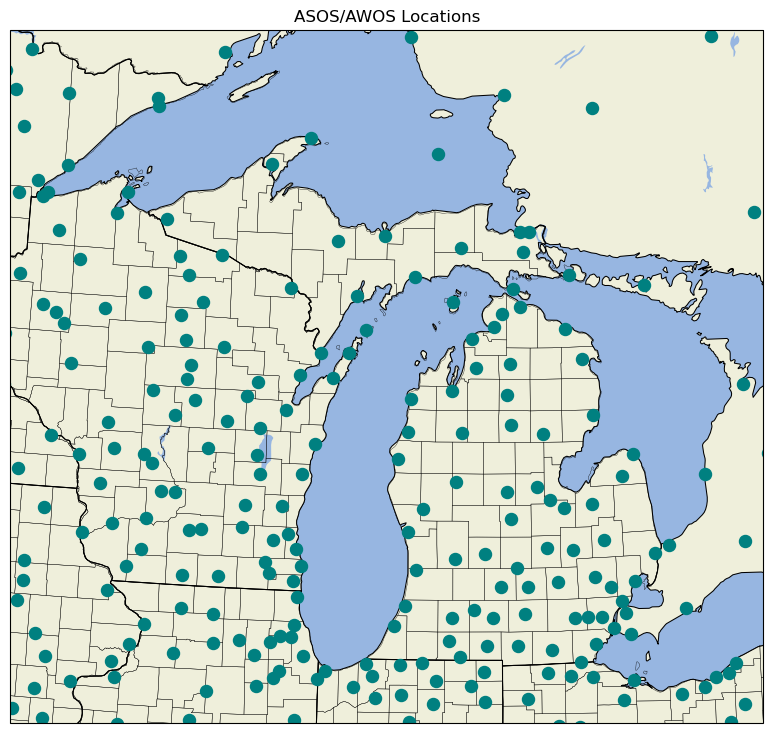

In [44]:
crs = ccrs.LambertConformal(central_longitude=-85, central_latitude=40)
datacrs = ccrs.PlateCarree() 

fig = plt.figure(figsize=(12,9))

ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent([-92, -81.0, 41, 48.5], datacrs)
ax.add_feature(cfeature.STATES, linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25)
ax.add_feature(cfeature.LAKES, zorder=1)
ax.add_feature(cfeature.LAND)

ax.scatter(df['longitude'], df['latitude'], c='teal', transform=datacrs, s=75, zorder=2)
plt.title('ASOS/AWOS Locations')